In [ ]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from  tensorflow.keras.initializers import *
from tensorflow.keras.layers import*
import collections
import tensorflow as tf
import tensorflow_addons as tfa

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  except RuntimeError as e:
    print(e)

In [ ]:
def SPP_variant3(x1,x2,x3):
    x11 = SeparableConv2D(16, 3, activation = 'relu', padding = 'same', strides = (4,4), kernel_initializer = 'random_normal')(x1)
    x22 = SeparableConv2D(32, 3, activation = 'relu', padding = 'same', strides = (2,2), kernel_initializer = 'random_normal')(x2)
    x33 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(x3)
    x = Concatenate()([x11,x22,x33])
    x = SeparableConv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    d = GlobalAveragePooling2D()(x)
    x_out = Multiply()([x3,d])
    x_out = Conv2D(64,(1,1), activation='relu')(x_out)
    x_o = MaxPooling2D((2,2))(x_out)
    x1 = tf.keras.layers.DepthwiseConv2D((3, 3), dilation_rate = (1,1), activation='relu', padding='same')(x_o)
    x2 = tf.keras.layers.DepthwiseConv2D((3, 3), dilation_rate = (2,2), activation='relu', padding='same')(x_o)
    x3 = tf.keras.layers.DepthwiseConv2D((3, 3), dilation_rate = (4,4), activation='relu', padding='same')(x_o)
    x4 = tf.keras.layers.DepthwiseConv2D((3, 3), dilation_rate = (6,6), activation='relu', padding='same')(x_o)
    x4 = Add()([x1,x2,x3,x4])
    x_o = Conv2D(128,(1,1), activation='relu')(x4)
    return x_o

In [ ]:
def se_block1(block_input, num_filters, ratio=2):

	pool1 = tf.keras.layers.GlobalAveragePooling2D()(block_input)
	flat = tf.keras.layers.Reshape((1, 1, num_filters))(pool1)
	dense1 = tf.keras.layers.Dense(num_filters//ratio, activation='relu')(flat)
	dense2 = tf.keras.layers.Dense(num_filters, activation='sigmoid')(dense1)
	scale = tf.keras.layers.multiply([block_input, dense2])

	return scale
def se_block2(block_input, num_filters, ratio=4):

	pool1 = tf.keras.layers.GlobalAveragePooling2D()(block_input)
	flat = tf.keras.layers.Reshape((1, 1, num_filters))(pool1)
	dense1 = tf.keras.layers.Dense(num_filters//ratio, activation='relu')(flat)
	dense2 = tf.keras.layers.Dense(num_filters, activation='sigmoid')(dense1)
	scale = tf.keras.layers.multiply([block_input, dense2])

	return scale
def se_block3(block_input, num_filters, ratio=8):

	pool1 = tf.keras.layers.GlobalAveragePooling2D()(block_input)
	flat = tf.keras.layers.Reshape((1, 1, num_filters))(pool1)
	dense1 = tf.keras.layers.Dense(num_filters//ratio, activation='relu')(flat)
	dense2 = tf.keras.layers.Dense(num_filters, activation='sigmoid')(dense1)
	scale = tf.keras.layers.multiply([block_input, dense2])

	return scale

def resnet_block(block_input, num_filters):

	if tf.keras.backend.int_shape(block_input)[3] != num_filters:
		block_input = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1))(block_input)
	conv1 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same')(block_input)
	norm1 = tf.keras.layers.BatchNormalization()(conv1)
	relu1 = tf.keras.layers.Activation('relu')(norm1)
	se1 = se_block1(relu1, num_filters=num_filters)
	conv2 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same')(block_input)
	norm2 = tf.keras.layers.BatchNormalization()(conv2)
	relu2 = tf.keras.layers.Activation('relu')(norm2)
	se2 = se_block2(relu2, num_filters=num_filters)
	conv3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same')(block_input)
	norm3 = tf.keras.layers.BatchNormalization()(conv3)
	relu3 = tf.keras.layers.Activation('relu')(norm3)
	se3 = se_block3(relu3, num_filters=num_filters)
	sum = tf.keras.layers.Add()([block_input, se1,se2,se3])
	relu4 = tf.keras.layers.Activation('relu')(sum)
	return relu4

In [ ]:
def ProposedNet(input_shape=(224,224,3), n_classes=4):
  init = Input(input_shape)

  x = Conv2D(16, (7, 7), activation=None, padding='same')(init)
  x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
  x = Activation('relu')(x)

#   x1 = resnet_block(x,16)
  x1 = resnet_block(x,16)
  x11 = MaxPooling2D((2,2))(x)

  x = Conv2D(32, (3, 3), activation=None, padding='same')(x11)
  x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
  x = Activation('relu')(x)

  x2 = resnet_block(x,32)
#   x2 = resnet_block(x,32)
  x22 = MaxPooling2D((2,2))(x)

  x = Conv2D(64, (3, 3), activation=None, padding='same')(x22)
  x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
  x = Activation('relu')(x)

  x3 = resnet_block(x,64)
#   x3 = MaxPooling2D((2,2))(x)

  x = SPP_variant3(x1,x2,x3)
  avg = GlobalAveragePooling2D()(x)

  y = Dense(n_classes, activation="softmax", name="ProposedNet")(avg)
  model = Model(init, y)
  return model

In [ ]:
model = ProposedNet(input_shape=(224,224,3), n_classes=4)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = 'E:/TGCA Extended Dataset-2/Training'
test_path = 'E:/TGCA Extended Dataset-2/Test'
val_path = 'E:/TGCA Extended Dataset-2/Validation'
batch_size = 4
img_height = 224
img_width = 224
no_of_classes = 4
classes_name = [0,1,2,3]
input_shape = (img_height , img_width , 3)


random_seed = np.random.seed(1142)

datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    horizontal_flip = False,
    vertical_flip = False,
    #validation_split = 0.1,
    featurewise_std_normalization=True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')


print(train_generator.class_indices)


Found 3769 images belonging to 4 classes.
Found 632 images belonging to 4 classes.
{'KICH': 0, 'KIRC': 1, 'KIRP': 2, 'Normal': 3}


In [ ]:
# from tensorflow.keras import regularizers
# for layer in model.layers:
#     if hasattr(layer, 'kernel_regularizer'):
#         layer.kernel_regularizer= regularizers.l2(0.003)

#     if hasattr(layer, 'bias_regularizer'):
#         layer.bias_regularizer= regularizers.l2(0.003)
# adam = tf.keras.optimizers.Adam(lr = 0.0001)
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=40, verbose=1,
                                              mode = 'max', restore_best_weights = True)
check_path = 'E:/save-2/R1.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


history_3A3 = model.fit_generator(train_generator , validation_data = validation_generator ,
                                  steps_per_epoch= len(train_generator) ,
                                  validation_steps = len(validation_generator)
                                  ,epochs = 65,callbacks = [reduce_lr, early_stop, checkpoint] )
# model_prop.load_weights('/content/drive/MyDrive/Major_project_data/Kidney_KMC/KMC_kidney_40x_dataset/Metrics/checkpoint_anirudh_7.h5')

C:\Users\ISRO-PROJECT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\ISRO-PROJECT\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\ISRO-PROJECT\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/65
943/943 [==============================] - 75s 73ms/step - loss: 1.1787 - acc: 0.4810 - val_loss: 1.0964 - val_acc: 0.6013

Epoch 00001: val_acc improved from -inf to 0.60127, saving model to E:/save-2\R1.h5
Epoch 2/65
943/943 [==============================] - 68s 72ms/step - loss: 0.9723 - acc: 0.5845 - val_loss: 0.8213 - val_acc: 0.6440

Epoch 00002: val_acc improved from 0.60127 to 0.64399, saving model to E:/save-2\R1.h5
Epoch 3/65
943/943 [==============================] - 68s 72ms/step - loss: 0.8924 - acc: 0.6419 - val_loss: 0.8430 - val_acc: 0.6519

Epoch 00003: val_acc improved from 0.64399 to 0.65190, saving model to E:/save-2\R1.h5
Epoch 4/65
943/943 [==============================] - 68s 72ms/step - loss: 0.8401 - acc: 0.6479 - val_loss: 0.6649 - val_acc: 0.7120

Epoch 00004: val_acc improved from 0.65190 to 0.71203, saving model to E:/save-2\R1.h5
Epoch 5/65
943/943 [==============================] - 68s 72ms/step - loss: 0.7770 - acc: 0.6863 - val_loss: 0.6903

In [ ]:
np.save('E:/save-2/R1.npy',history_3A3.history)

In [ ]:
import numpy as np
history_3A3 = np.load('E:/save-2/R1.npy',allow_pickle='TRUE').item()

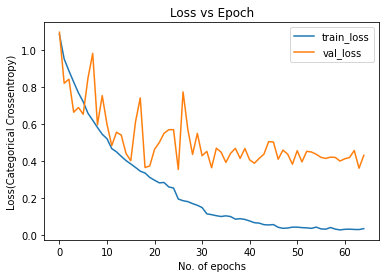

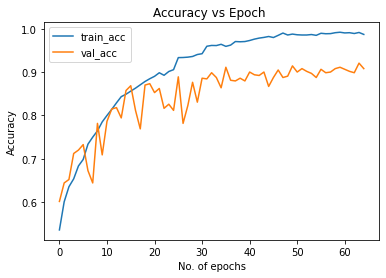

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_3A3['loss'] , label = 'train_loss')
plt.plot(history_3A3['val_loss'] , label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss(Categorical Crossentropy)")
plt.title("Loss vs Epoch")
plt.savefig('E:/save-2/R1_loss.png')
plt.show()
#plt.savefig('90.98_loss.png')
plt.plot(history_3A3['acc'] , label = 'train_acc')
plt.plot(history_3A3['val_acc'] , label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch ")
plt.savefig('E:/save-2/R1_accuracy.png')
plt.show()

In [ ]:
model.load_weights('E:/save-2/R1.h5')

In [ ]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory(
    'E:/TGCA Extended Dataset-2/Test',
    target_size=(224,224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

Found 632 images belonging to 4 classes.


In [ ]:
import numpy as np
test_step = test.n//test.batch_size
test.reset()
pred = model.predict_generator(test , steps = test_step , verbose = 1)
pred_class_indices = np.argmax(pred,axis=1)

## printing predicted labels
print(pred_class_indices)

C:\Users\ISRO-PROJECT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


632/632 [==============================] - 12s 17ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 3 0 2 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 2 0 0 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 2 0 0 2 0 0
 0 0 0 0 0 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1
 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 2 2 2 0 3 3 3 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 

In [ ]:
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score,jaccard_score,classification_report
from sklearn.metrics import precision_score,recall_score,jaccard_score
classes = [0,1,2,3]


for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_______________________________")

class:  0
Accuracy 0.9667721518987342
F1 0.932475884244373
precision 0.9477124183006536
recall 0.9177215189873418
jaccard 0.8734939759036144
_______________________________
class:  1
Accuracy 0.9762658227848101
F1 0.9523809523809524
precision 0.9554140127388535
recall 0.9493670886075949
jaccard 0.9090909090909091
_______________________________
class:  2
Accuracy 0.9367088607594937
F1 0.8780487804878048
precision 0.8470588235294118
recall 0.9113924050632911
jaccard 0.782608695652174
_______________________________
class:  3
Accuracy 0.9620253164556962
F1 0.9225806451612903
precision 0.9407894736842105
recall 0.9050632911392406
jaccard 0.8562874251497006
_______________________________


In [ ]:
print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Accuracy 0.9208860759493671
F1 0.9213715655686052
precision 0.9227436820632824
recall 0.920886075949367
jaccard 0.8553702514490995
confusion_matrix
 [[145   0  11   2]
 [  0 150   7   1]
 [  6   2 144   6]
 [  2   5   8 143]]
classification_report
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       158
           1       0.96      0.95      0.95       158
           2       0.85      0.91      0.88       158
           3       0.94      0.91      0.92       158

    accuracy                           0.92       632
   macro avg       0.92      0.92      0.92       632
weighted avg       0.92      0.92      0.92       632






In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = [ "Normal","KICH","KIRC","KIRP"]
plot_confusion_matrix(cm, labels,
                        normalize=False,
                        title='Confusion Matrix For Proposed Model',
                        cmap=plt.cm.Blues)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
# plt.title("Confusion matrix")
plt.savefig('E:/Data_2/TGCA/plot/Proposed-Model-Confusion-Matrix-Extended-Data_3A3.png')
plt.show()

In [ ]:
from sklearn.metrics import *

for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    fpr,tpr,_ = roc_curve(a1,a2)
    roc_auc = auc(fpr,tpr)

    plt.plot(fpr,tpr,label = "ROC curve of class " + str(cl) + " AUC: " + str(roc_auc))

plt.title("ROC-AUC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.savefig('E:/Data_2/TGCA/plot/Proposed-Model-ROC-AUC-Extended-Data_3A3.png')
plt.show()